# SME Market Segmentation  
# Part 1 - Preparing Data

*By Ricky Soo*  
*19th November 2020*  
*https://github.com/rickysoo*

How can a bank serve its customers better? How can it better position itself to provide loans to the small and medium sized enterprises (SMEs) to help them in their business?

Given 3 sets of data - SME bank accounts information, bank transactions in 2018, and bank transactions in 2019, let's segment the SME market into different clusters to gain insights into their individual characteristics and behaviors.

In this study, the usual data science process is followed to gain insights into the available data. The k-means algorithm is used to cluster the existing 112,618 customer accounts into 6 clusters. Insights are gained from each clusters.

## 1. Preparing Data - SME Info

In this section, data on SME accounts are loaded, explored and cleaned.

### Import Libraries

In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

from scipy import stats
import joblib

### Loading Data

In [3]:
df_sme_info = pd.read_csv('sme_info.csv')
df_sme_info.head()

,Customer Account ID,Customer Company ID,Borrowing/Non-Borrowing Customer,Asset/Liability,Product Category,Operating Years,Industry Sector,Constitution_description,Islamic_Tagging (Yes/No),State,Product Type,Tenor
0,Cust_Acct_ID_000001,Cust_Party_ID_122133,Non-borrowing,Liability,Deposits,19.0,Wholesale & Retail Trade,PARTNERSHIP,N,SABAH,CA,0
1,Cust_Acct_ID_000002,Cust_Party_ID_059101,Non-borrowing,Liability,Deposits,4.0,Wholesale & Retail Trade,SOLE PROPRIETOR,Y,KUALA LUMPUR,CA,0
2,Cust_Acct_ID_000003,Cust_Party_ID_081657,Non-borrowing,Liability,Deposits,4.0,"Transport, Storage & Communication",SOLE PROPRIETOR,N,PERAK,CA,0
3,Cust_Acct_ID_000004,Cust_Party_ID_010950,Non-borrowing,Liability,Deposits,12.0,Manufacturing,SOLE PROPRIETOR,Y,TERENGGANU,CA,0
4,Cust_Acct_ID_000005,Cust_Party_ID_092549,Non-borrowing,Liability,Deposits,5.0,Real Estate,SDN BHD/PRIVATE LTD,N,KUALA LUMPUR,CA,0


In [5]:
df_sme_info.shape

(141749, 12)

In [6]:
df_sme_info.columns

Index(['Customer Account ID', 'Customer Company ID',
       'Borrowing/Non-Borrowing Customer', 'Asset/Liability',
       'Product Category', 'Operating Years', 'Industry Sector',
       'Constitution_description', 'Islamic_Tagging (Yes/No)', 'State',
       'Product Type', 'Tenor'],
      dtype='object')

Change the column names for easier data wrangling.

In [7]:
df_sme_info.columns = ['AccountID', 'CompanyID', 'Borrowing', 'Asset', 'Product', 'Years', 'Industry', 'ConstType', 'Islamic', 'State', 'ProductType', 'Tenor']

In [8]:
df_sme_info.columns

Index(['AccountID', 'CompanyID', 'Borrowing', 'Asset', 'Product', 'Years',
       'Industry', 'ConstType', 'Islamic', 'State', 'ProductType', 'Tenor'],
      dtype='object')

In [9]:
df_sme_info.head()

,AccountID,CompanyID,Borrowing,Asset,Product,Years,Industry,ConstType,Islamic,State,ProductType,Tenor
0,Cust_Acct_ID_000001,Cust_Party_ID_122133,Non-borrowing,Liability,Deposits,19.0,Wholesale & Retail Trade,PARTNERSHIP,N,SABAH,CA,0
1,Cust_Acct_ID_000002,Cust_Party_ID_059101,Non-borrowing,Liability,Deposits,4.0,Wholesale & Retail Trade,SOLE PROPRIETOR,Y,KUALA LUMPUR,CA,0
2,Cust_Acct_ID_000003,Cust_Party_ID_081657,Non-borrowing,Liability,Deposits,4.0,"Transport, Storage & Communication",SOLE PROPRIETOR,N,PERAK,CA,0
3,Cust_Acct_ID_000004,Cust_Party_ID_010950,Non-borrowing,Liability,Deposits,12.0,Manufacturing,SOLE PROPRIETOR,Y,TERENGGANU,CA,0
4,Cust_Acct_ID_000005,Cust_Party_ID_092549,Non-borrowing,Liability,Deposits,5.0,Real Estate,SDN BHD/PRIVATE LTD,N,KUALA LUMPUR,CA,0


### Data Wrangling

Check data for missing values.

In [10]:
df_sme_info.isnull().sum()

AccountID       0
CompanyID      22
Borrowing       0
Asset           0
Product         0
Years          24
Industry        0
ConstType       0
Islamic         0
State           0
ProductType     0
Tenor           0
dtype: int64

**CompanyID** - Drop the Company ID column as we will use the Account ID column for identifying bank accounts and joining tables.

In [11]:
df_sme_info.drop('CompanyID', axis = 1, inplace = True)

**Years** - The operating years info is missing in 24 accounts. Remove the accounts as the number is small and they are missing in random.

In [12]:
df_sme_info.drop(df_sme_info[df_sme_info['Years'].isnull()].index, inplace = True)

In [13]:
df_sme_info.isnull().sum()

AccountID      0
Borrowing      0
Asset          0
Product        0
Years          0
Industry       0
ConstType      0
Islamic        0
State          0
ProductType    0
Tenor          0
dtype: int64

**AccountID** - Slice the Account ID into 6 digits.

In [14]:
df_sme_info['AccountID'] = df_sme_info['AccountID'].str.slice(-6)

In [15]:
df_sme_info.head()

,AccountID,Borrowing,Asset,Product,Years,Industry,ConstType,Islamic,State,ProductType,Tenor
0,000001,Non-borrowing,Liability,Deposits,19.0,Wholesale & Retail Trade,PARTNERSHIP,N,SABAH,CA,0
1,000002,Non-borrowing,Liability,Deposits,4.0,Wholesale & Retail Trade,SOLE PROPRIETOR,Y,KUALA LUMPUR,CA,0
2,000003,Non-borrowing,Liability,Deposits,4.0,"Transport, Storage & Communication",SOLE PROPRIETOR,N,PERAK,CA,0
3,000004,Non-borrowing,Liability,Deposits,12.0,Manufacturing,SOLE PROPRIETOR,Y,TERENGGANU,CA,0
4,000005,Non-borrowing,Liability,Deposits,5.0,Real Estate,SDN BHD/PRIVATE LTD,N,KUALA LUMPUR,CA,0


**Borrowing** - Remove the accounts who are already borrowers. Focus on those who are not yet borrowers.

In [16]:
df_sme_info['Borrowing'].value_counts()

Non-borrowing    137587
Borrowing          4138
Name: Borrowing, dtype: int64

In [17]:
df_sme_info.drop(df_sme_info[df_sme_info['Borrowing'] == 'Borrowing'].index, inplace = True)

In [18]:
df_sme_info.drop(['Borrowing'], axis = 1, inplace = True)

In [19]:
df_sme_info.head()

,AccountID,Asset,Product,Years,Industry,ConstType,Islamic,State,ProductType,Tenor
0,000001,Liability,Deposits,19.0,Wholesale & Retail Trade,PARTNERSHIP,N,SABAH,CA,0
1,000002,Liability,Deposits,4.0,Wholesale & Retail Trade,SOLE PROPRIETOR,Y,KUALA LUMPUR,CA,0
2,000003,Liability,Deposits,4.0,"Transport, Storage & Communication",SOLE PROPRIETOR,N,PERAK,CA,0
3,000004,Liability,Deposits,12.0,Manufacturing,SOLE PROPRIETOR,Y,TERENGGANU,CA,0
4,000005,Liability,Deposits,5.0,Real Estate,SDN BHD/PRIVATE LTD,N,KUALA LUMPUR,CA,0


**Asset** - Drop the column as all of them are liabilities (after previous data cleaning).

In [20]:
df_sme_info['Asset'].value_counts()

Liability    137587
Name: Asset, dtype: int64

In [21]:
df_sme_info.drop(['Asset'], axis = 1, inplace = True)

In [22]:
df_sme_info.head()

,AccountID,Product,Years,Industry,ConstType,Islamic,State,ProductType,Tenor
0,000001,Deposits,19.0,Wholesale & Retail Trade,PARTNERSHIP,N,SABAH,CA,0
1,000002,Deposits,4.0,Wholesale & Retail Trade,SOLE PROPRIETOR,Y,KUALA LUMPUR,CA,0
2,000003,Deposits,4.0,"Transport, Storage & Communication",SOLE PROPRIETOR,N,PERAK,CA,0
3,000004,Deposits,12.0,Manufacturing,SOLE PROPRIETOR,Y,TERENGGANU,CA,0
4,000005,Deposits,5.0,Real Estate,SDN BHD/PRIVATE LTD,N,KUALA LUMPUR,CA,0


**Product** - Drop the column as all of them are deposits (after previous data cleaning).

In [23]:
df_sme_info['Product'].value_counts()

Deposits    137587
Name: Product, dtype: int64

In [24]:
df_sme_info.drop('Product', axis = 1, inplace = True)

In [25]:
df_sme_info.head()

,AccountID,Years,Industry,ConstType,Islamic,State,ProductType,Tenor
0,000001,19.0,Wholesale & Retail Trade,PARTNERSHIP,N,SABAH,CA,0
1,000002,4.0,Wholesale & Retail Trade,SOLE PROPRIETOR,Y,KUALA LUMPUR,CA,0
2,000003,4.0,"Transport, Storage & Communication",SOLE PROPRIETOR,N,PERAK,CA,0
3,000004,12.0,Manufacturing,SOLE PROPRIETOR,Y,TERENGGANU,CA,0
4,000005,5.0,Real Estate,SDN BHD/PRIVATE LTD,N,KUALA LUMPUR,CA,0


**Industry** - Convert into dummy variables.

In [26]:
df_sme_info['Industry'].value_counts()

Wholesale & Retail Trade              50296
Finance/Insurance/Services            25985
Construction                          17946
Education, Health and Others          13317
Manufacturing                         12910
Transport, Storage & Communication     8073
Real Estate                            3245
Agriculture                            3103
Electricity, Gas & Water               1680
Mining & quarrying                      550
Others                                  242
Household                               240
Name: Industry, dtype: int64

In [27]:
df_sme_info['Industry'].replace({
    'Wholesale & Retail Trade': 'Trade',
    'Finance/Insurance/Services': 'Finance',
    'Construction': 'Construction',
    'Manufacturing': 'Manufacturing',
    'Education, Health and Others': 'EducationHealth',
    'Transport, Storage & Communication': 'Logistics',
    'Real Estate': 'RealEstate',
    'Agriculture': 'Agriculture',
    'Electricity, Gas & Water': 'Utilities',
    'Mining & quarrying': 'Mining',
    'Household': 'Household',
    'Others': 'Others'
}, inplace = True)

In [28]:
df_sme_info = pd.get_dummies(df_sme_info, columns = ['Industry'])

In [30]:
df_sme_info.head()

,AccountID,Years,ConstType,Islamic,State,ProductType,Tenor,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,Industry_Household,Industry_Logistics,Industry_Manufacturing,Industry_Mining,Industry_Others,Industry_RealEstate,Industry_Trade,Industry_Utilities
0,000001,19.0,PARTNERSHIP,N,SABAH,CA,0,0,0,0,0,0,0,0,0,0,0,1,0
1,000002,4.0,SOLE PROPRIETOR,Y,KUALA LUMPUR,CA,0,0,0,0,0,0,0,0,0,0,0,1,0
2,000003,4.0,SOLE PROPRIETOR,N,PERAK,CA,0,0,0,0,0,0,1,0,0,0,0,0,0
3,000004,12.0,SOLE PROPRIETOR,Y,TERENGGANU,CA,0,0,0,0,0,0,0,1,0,0,0,0,0
4,000005,5.0,SDN BHD/PRIVATE LTD,N,KUALA LUMPUR,CA,0,0,0,0,0,0,0,0,0,0,1,0,0


**ConstType** - Convert into dummy variables. Drop a number of accounts which are not SMES or are small in numbers.

In [31]:
df_sme_info['ConstType'].value_counts()

SOLE PROPRIETOR         72456
SDN BHD/PRIVATE LTD     41721
PARTNERSHIP             21239
ASSOC/SCHOOL/SOCIETY     1958
BHD/PUBLIC LTD CO          79
OTHERS                     62
COOPERATIVE                37
DNFI-Others                34
MERCHANT BANK               1
Name: ConstType, dtype: int64

In [32]:
df_sme_info['ConstType'].replace({
    'SOLE PROPRIETOR': 'SoleProprietor',
    'SDN BHD/PRIVATE LTD': 'PrivateLtd',
    'PARTNERSHIP': 'Partnership',
    'ASSOC/SCHOOL/SOCIETY': 'SchoolSociety',
    'BHD/PUBLIC LTD CO': 'PublicLtd',
    'OTHERS': 'Others',
    'COOPERATIVE': 'Cooperative',
    'DNFI-Others': 'DNFI',
    'MERCHANT BANK': 'Bank'
}, inplace = True)

In [33]:
df_sme_info.drop(df_sme_info[df_sme_info['ConstType'] == 'Others'].index, inplace = True)

In [34]:
df_sme_info.drop(df_sme_info[df_sme_info['ConstType'] == 'Cooperative'].index, inplace = True)

In [35]:
df_sme_info.drop(df_sme_info[df_sme_info['ConstType'] == 'DNFI'].index, inplace = True)

In [36]:
df_sme_info.drop(df_sme_info[df_sme_info['ConstType'] == 'Bank'].index, inplace = True)

In [37]:
df_sme_info = pd.get_dummies(df_sme_info, columns = ['ConstType'])

In [38]:
df_sme_info.head()

,AccountID,Years,Islamic,State,ProductType,Tenor,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,...,Industry_Mining,Industry_Others,Industry_RealEstate,Industry_Trade,Industry_Utilities,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor
0,000001,19.0,N,SABAH,CA,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,000002,4.0,Y,KUALA LUMPUR,CA,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,000003,4.0,N,PERAK,CA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,000004,12.0,Y,TERENGGANU,CA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,000005,5.0,N,KUALA LUMPUR,CA,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


**Islamic** - Keep the column.

In [39]:
df_sme_info['Islamic'].value_counts()

N    111053
Y     26400
Name: Islamic, dtype: int64

In [40]:
df_sme_info['Islamic'].replace({'N': 0, 'Y': 1}, inplace = True)

In [41]:
df_sme_info['Islamic'].value_counts()

0    111053
1     26400
Name: Islamic, dtype: int64

In [42]:
df_sme_info.head()

,AccountID,Years,Islamic,State,ProductType,Tenor,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,...,Industry_Mining,Industry_Others,Industry_RealEstate,Industry_Trade,Industry_Utilities,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor
0,000001,19.0,0,SABAH,CA,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,000002,4.0,1,KUALA LUMPUR,CA,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,000003,4.0,0,PERAK,CA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,000004,12.0,1,TERENGGANU,CA,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,000005,5.0,0,KUALA LUMPUR,CA,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


**State** - Remove a number of accounts which are not in Malaysia. Drop the column as it will not be used in model training. Nowadays, geographical location is not as vital as before as banking goes digital.

In [43]:
df_sme_info['State'].value_counts()

SELANGOR        43163
KUALA LUMPUR    24306
JOHOR           17858
PENANG          10303
SARAWAK          9782
PERAK            6598
SABAH            5003
KEDAH            4931
N.SEMBILAN       4306
PAHANG           3915
MALACCA          2521
TERENGGANU       1925
others           1671
KELANTAN          519
PERLIS            358
Foreign           294
Name: State, dtype: int64

In [44]:
df_sme_info.drop(df_sme_info[df_sme_info['State'] == 'Others'].index, inplace = True)

In [45]:
df_sme_info.drop(df_sme_info[df_sme_info['State'] == 'Foreign'].index, inplace = True)

In [46]:
df_sme_info.drop('State', axis = 1, inplace = True)

In [47]:
df_sme_info.head()

,AccountID,Years,Islamic,ProductType,Tenor,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,Industry_Household,...,Industry_Mining,Industry_Others,Industry_RealEstate,Industry_Trade,Industry_Utilities,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor
0,000001,19.0,0,CA,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,000002,4.0,1,CA,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,000003,4.0,0,CA,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,000004,12.0,1,CA,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,000005,5.0,0,CA,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


**Products** - Convert into dummy variables.

In [48]:
df_sme_info['ProductType'].value_counts()

CA    137138
SA        21
Name: ProductType, dtype: int64

In [49]:
df_sme_info = pd.get_dummies(df_sme_info, columns = ['ProductType'])

In [50]:
df_sme_info.head()

,AccountID,Years,Islamic,Tenor,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,Industry_Household,Industry_Logistics,...,Industry_RealEstate,Industry_Trade,Industry_Utilities,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor,ProductType_CA,ProductType_SA
0,000001,19.0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
1,000002,4.0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,000003,4.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
3,000004,12.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,000005,5.0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


**Tenor** - Drop the column as it has only one value.

In [51]:
df_sme_info['Tenor'].value_counts()

0    137159
Name: Tenor, dtype: int64

In [52]:
df_sme_info.drop('Tenor', axis = 1, inplace = True)

In [53]:
df_sme_info.head()

,AccountID,Years,Islamic,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,Industry_Household,Industry_Logistics,Industry_Manufacturing,...,Industry_RealEstate,Industry_Trade,Industry_Utilities,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor,ProductType_CA,ProductType_SA
0,000001,19.0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
1,000002,4.0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,000003,4.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
3,000004,12.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
4,000005,5.0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


Save the data for future retrieval.

In [54]:
df_sme_info.to_csv('sme_info_cleaned.csv', index = False)

## 2. Preparing Data - SME Transactions

### 2018 Data

In this section, the 2018 SME transaction data is loaded, explored and cleaned.

In [55]:
df_sme_2018 = pd.read_csv('sme_2018.csv')

In [56]:
df_sme_2018.head()

,Customer Account ID,Customer Company ID,Borrowing/Non-Borrowing Customer,Balance_December,Balance_November,Balance_October,Balance_September,Balance_August,Balance_July,Balance_June,...,Total Debit Count_March,Total Debit Count_April,Total Debit Count_May,Total Debit Count_June,Total Debit Count_July,Total Debit Count_August,Total Debit Count_September,Total Debit Count_October,Total Debit Count_November,Total Debit Count_December
0,Cust_Acct_ID_000001,Cust_Party_ID_122133,Non-borrowing,10213.52,13661.78,4733.90,13808.25,22176.04,12887.73,34793.38,...,22.0,24.0,31.0,19.0,26.0,20.0,16.0,19.0,27.0,16.0
1,Cust_Acct_ID_000002,Cust_Party_ID_059101,Non-borrowing,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN
2,Cust_Acct_ID_000004,Cust_Party_ID_010950,Non-borrowing,0.00,51.78,2.72,23.90,23.90,31.90,32.40,...,7.0,1.0,3.0,1.0,3.0,1.0,NaN,14.0,15.0,3.0
3,Cust_Acct_ID_000005,Cust_Party_ID_092549,Non-borrowing,303275.05,289022.95,377292.55,413555.95,548492.97,498688.25,493999.95,...,133.0,108.0,101.0,69.0,87.0,82.0,74.0,61.0,92.0,65.0
4,Cust_Acct_ID_000006,Cust_Party_ID_132914,Non-borrowing,982.50,992.50,992.50,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0


In [57]:
df_sme_2018.shape

(118435, 63)

Rename into AccountID column.

In [58]:
df_sme_2018.rename(columns = {
    'Customer Account ID': 'AccountID'
}, inplace = True)

In [59]:
df_sme_2018['AccountID'] = df_sme_2018['AccountID'].str.slice(-6)

In [60]:
df_sme_2018.drop(['Customer Company ID', 'Borrowing/Non-Borrowing Customer'], axis = 1, inplace = True)

In [61]:
df_sme_2018.head()

,AccountID,Balance_December,Balance_November,Balance_October,Balance_September,Balance_August,Balance_July,Balance_June,Balance_May,Balance_April,...,Total Debit Count_March,Total Debit Count_April,Total Debit Count_May,Total Debit Count_June,Total Debit Count_July,Total Debit Count_August,Total Debit Count_September,Total Debit Count_October,Total Debit Count_November,Total Debit Count_December
0,000001,10213.52,13661.78,4733.90,13808.25,22176.04,12887.73,34793.38,22606.71,49314.03,...,22.0,24.0,31.0,19.0,26.0,20.0,16.0,19.0,27.0,16.0
1,000002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,...,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN
2,000004,0.00,51.78,2.72,23.90,23.90,31.90,32.40,42.40,242.90,...,7.0,1.0,3.0,1.0,3.0,1.0,NaN,14.0,15.0,3.0
3,000005,303275.05,289022.95,377292.55,413555.95,548492.97,498688.25,493999.95,356970.55,420866.65,...,133.0,108.0,101.0,69.0,87.0,82.0,74.0,61.0,92.0,65.0
4,000006,982.50,992.50,992.50,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0


In [62]:
df_sme_2018.shape

(118435, 61)

Check for missing values. Replace with 0 for all the missing balances, amounts and number of transactions.

In [63]:
dict(df_sme_2018.isnull().sum())

{'AccountID': 0,
 'Balance_December': 0,
 'Balance_November': 0,
 'Balance_October': 0,
 'Balance_September': 0,
 'Balance_August': 0,
 'Balance_July': 0,
 'Balance_June': 0,
 'Balance_May': 0,
 'Balance_April': 0,
 'Balance_March': 0,
 'Balance_February': 0,
 'Balance_January': 0,
 'Total Credit Amount_January': 49267,
 'Total Credit Amount_February': 49863,
 'Total Credit Amount_March': 48359,
 'Total Credit Amount_April': 47049,
 'Total Credit Amount_May': 46770,
 'Total Credit Amount_June': 46157,
 'Total Credit Amount_July': 36211,
 'Total Credit Amount_August': 33271,
 'Total Credit Amount_September': 43692,
 'Total Credit Amount_October': 40483,
 'Total Credit Amount_November': 40721,
 'Total Credit Amount_December': 39863,
 'Total Debit Amount_January': 48893,
 'Total Debit Amount_February': 49575,
 'Total Debit Amount_March': 47472,
 'Total Debit Amount_April': 46496,
 'Total Debit Amount_May': 46117,
 'Total Debit Amount_June': 25306,
 'Total Debit Amount_July': 35823,
 'Tota

In [64]:
df_sme_2018.fillna(0, inplace = True)

In [65]:
dict(df_sme_2018.isnull().sum())

{'AccountID': 0,
 'Balance_December': 0,
 'Balance_November': 0,
 'Balance_October': 0,
 'Balance_September': 0,
 'Balance_August': 0,
 'Balance_July': 0,
 'Balance_June': 0,
 'Balance_May': 0,
 'Balance_April': 0,
 'Balance_March': 0,
 'Balance_February': 0,
 'Balance_January': 0,
 'Total Credit Amount_January': 0,
 'Total Credit Amount_February': 0,
 'Total Credit Amount_March': 0,
 'Total Credit Amount_April': 0,
 'Total Credit Amount_May': 0,
 'Total Credit Amount_June': 0,
 'Total Credit Amount_July': 0,
 'Total Credit Amount_August': 0,
 'Total Credit Amount_September': 0,
 'Total Credit Amount_October': 0,
 'Total Credit Amount_November': 0,
 'Total Credit Amount_December': 0,
 'Total Debit Amount_January': 0,
 'Total Debit Amount_February': 0,
 'Total Debit Amount_March': 0,
 'Total Debit Amount_April': 0,
 'Total Debit Amount_May': 0,
 'Total Debit Amount_June': 0,
 'Total Debit Amount_July': 0,
 'Total Debit Amount_August': 0,
 'Total Debit Amount_September': 0,
 'Total Debit

In [66]:
df_sme_2018.head()

,AccountID,Balance_December,Balance_November,Balance_October,Balance_September,Balance_August,Balance_July,Balance_June,Balance_May,Balance_April,...,Total Debit Count_March,Total Debit Count_April,Total Debit Count_May,Total Debit Count_June,Total Debit Count_July,Total Debit Count_August,Total Debit Count_September,Total Debit Count_October,Total Debit Count_November,Total Debit Count_December
0,000001,10213.52,13661.78,4733.90,13808.25,22176.04,12887.73,34793.38,22606.71,49314.03,...,22.0,24.0,31.0,19.0,26.0,20.0,16.0,19.0,27.0,16.0
1,000002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,...,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0
2,000004,0.00,51.78,2.72,23.90,23.90,31.90,32.40,42.40,242.90,...,7.0,1.0,3.0,1.0,3.0,1.0,0.0,14.0,15.0,3.0
3,000005,303275.05,289022.95,377292.55,413555.95,548492.97,498688.25,493999.95,356970.55,420866.65,...,133.0,108.0,101.0,69.0,87.0,82.0,74.0,61.0,92.0,65.0
4,000006,982.50,992.50,992.50,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### 2019 Data

In this section, the 2019 SME transaction data is loaded, explored and cleaned.

In [67]:
df_sme_2019 = pd.read_csv('sme_2019.csv')

In [68]:
df_sme_2019.head()

,Customer Account ID,Customer Company ID,Borrowing/Non-Borrowing Customer,Balance_December,Balance_November,Balance_October,Balance_September,Balance_August,Balance_July,Balance_June,...,Total Debit Count_March,Total Debit Count_April,Total Debit Count_May,Total Debit Count_June,Total Debit Count_July,Total Debit Count_August,Total Debit Count_September,Total Debit Count_October,Total Debit Count_November,Total Debit Count_December
0,Cust_Acct_ID_000001,Cust_Party_ID_122133,Non-borrowing,25151.78,4770.81,22164.26,14402.67,22927.88,20341.49,28378.77,...,27.0,15.0,19.0,15.0,26.0,15.0,17.0,13.0,15.0,13.0
1,Cust_Acct_ID_000002,Cust_Party_ID_059101,Non-borrowing,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cust_Acct_ID_000003,Cust_Party_ID_081657,Non-borrowing,42.32,3.38,7.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,17.0,9.0
3,Cust_Acct_ID_000004,Cust_Party_ID_010950,Non-borrowing,70.00,2.00,2.00,2.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,6.0
4,Cust_Acct_ID_000005,Cust_Party_ID_092549,Non-borrowing,246266.82,229649.52,172551.00,110279.28,231150.88,242288.65,203522.05,...,63.0,71.0,73.0,46.0,66.0,76.0,83.0,56.0,74.0,72.0


In [69]:
df_sme_2019.shape

(140894, 63)

Rename into AccountID column.

In [70]:
df_sme_2019.rename(columns = {
    'Customer Account ID': 'AccountID'
}, inplace = True)

In [71]:
df_sme_2019['AccountID'] = df_sme_2019['AccountID'].str.slice(-6)

In [72]:
df_sme_2019.drop(['Customer Company ID', 'Borrowing/Non-Borrowing Customer'], axis = 1, inplace = True)

In [73]:
df_sme_2019.head()

,AccountID,Balance_December,Balance_November,Balance_October,Balance_September,Balance_August,Balance_July,Balance_June,Balance_May,Balance_April,...,Total Debit Count_March,Total Debit Count_April,Total Debit Count_May,Total Debit Count_June,Total Debit Count_July,Total Debit Count_August,Total Debit Count_September,Total Debit Count_October,Total Debit Count_November,Total Debit Count_December
0,000001,25151.78,4770.81,22164.26,14402.67,22927.88,20341.49,28378.77,30688.41,37063.95,...,27.0,15.0,19.0,15.0,26.0,15.0,17.0,13.0,15.0,13.0
1,000002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000003,42.32,3.38,7.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,17.0,9.0
3,000004,70.00,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,6.0
4,000005,246266.82,229649.52,172551.00,110279.28,231150.88,242288.65,203522.05,227665.15,251274.15,...,63.0,71.0,73.0,46.0,66.0,76.0,83.0,56.0,74.0,72.0


In [74]:
df_sme_2019.shape

(140894, 61)

Check for missing values. Replace with 0 for all the missing balances, amounts and number of transactions.

In [75]:
dict(df_sme_2019.isnull().sum())

{'AccountID': 0,
 'Balance_December': 0,
 'Balance_November': 0,
 'Balance_October': 0,
 'Balance_September': 0,
 'Balance_August': 0,
 'Balance_July': 0,
 'Balance_June': 0,
 'Balance_May': 0,
 'Balance_April': 0,
 'Balance_March': 0,
 'Balance_February': 0,
 'Balance_January': 0,
 'Total Credit Amount_January': 59587,
 'Total Credit Amount_February': 63455,
 'Total Credit Amount_March': 59377,
 'Total Credit Amount_April': 57506,
 'Total Credit Amount_May': 56376,
 'Total Credit Amount_June': 61484,
 'Total Credit Amount_July': 57154,
 'Total Credit Amount_August': 56951,
 'Total Credit Amount_September': 57056,
 'Total Credit Amount_October': 54630,
 'Total Credit Amount_November': 54659,
 'Total Credit Amount_December': 53796,
 'Total Debit Amount_January': 59542,
 'Total Debit Amount_February': 62326,
 'Total Debit Amount_March': 58815,
 'Total Debit Amount_April': 57297,
 'Total Debit Amount_May': 56040,
 'Total Debit Amount_June': 32485,
 'Total Debit Amount_July': 54434,
 'Tota

In [76]:
df_sme_2019.fillna(0, inplace = True)

In [77]:
dict(df_sme_2019.isnull().sum())

{'AccountID': 0,
 'Balance_December': 0,
 'Balance_November': 0,
 'Balance_October': 0,
 'Balance_September': 0,
 'Balance_August': 0,
 'Balance_July': 0,
 'Balance_June': 0,
 'Balance_May': 0,
 'Balance_April': 0,
 'Balance_March': 0,
 'Balance_February': 0,
 'Balance_January': 0,
 'Total Credit Amount_January': 0,
 'Total Credit Amount_February': 0,
 'Total Credit Amount_March': 0,
 'Total Credit Amount_April': 0,
 'Total Credit Amount_May': 0,
 'Total Credit Amount_June': 0,
 'Total Credit Amount_July': 0,
 'Total Credit Amount_August': 0,
 'Total Credit Amount_September': 0,
 'Total Credit Amount_October': 0,
 'Total Credit Amount_November': 0,
 'Total Credit Amount_December': 0,
 'Total Debit Amount_January': 0,
 'Total Debit Amount_February': 0,
 'Total Debit Amount_March': 0,
 'Total Debit Amount_April': 0,
 'Total Debit Amount_May': 0,
 'Total Debit Amount_June': 0,
 'Total Debit Amount_July': 0,
 'Total Debit Amount_August': 0,
 'Total Debit Amount_September': 0,
 'Total Debit

### Combining 2018 and 2019 Data

In this section, both the 2018 and 2019 data are combined into one before merging with the SME accounts data.

Inner join is used to discard accounts are are missing in either one of the two years.

In [78]:
df_sme_2018_2019 = df_sme_2018.merge(df_sme_2019, how = 'inner', on = 'AccountID', suffixes = ['_2018', '_2019'])

In [79]:
df_sme_2018_2019.head()

,AccountID,Balance_December_2018,Balance_November_2018,Balance_October_2018,Balance_September_2018,Balance_August_2018,Balance_July_2018,Balance_June_2018,Balance_May_2018,Balance_April_2018,...,Total Debit Count_March_2019,Total Debit Count_April_2019,Total Debit Count_May_2019,Total Debit Count_June_2019,Total Debit Count_July_2019,Total Debit Count_August_2019,Total Debit Count_September_2019,Total Debit Count_October_2019,Total Debit Count_November_2019,Total Debit Count_December_2019
0,000001,10213.52,13661.78,4733.90,13808.25,22176.04,12887.73,34793.38,22606.71,49314.03,...,27.0,15.0,19.0,15.0,26.0,15.0,17.0,13.0,15.0,13.0
1,000002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000004,0.00,51.78,2.72,23.90,23.90,31.90,32.40,42.40,242.90,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,6.0
3,000005,303275.05,289022.95,377292.55,413555.95,548492.97,498688.25,493999.95,356970.55,420866.65,...,63.0,71.0,73.0,46.0,66.0,76.0,83.0,56.0,74.0,72.0
4,000006,982.50,992.50,992.50,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,4.0,3.0,1.0,2.0,2.0,2.0,4.0


In [80]:
df_sme_2018_2019.shape

(118431, 121)

In [81]:
list(df_sme_2018_2019.columns)

['AccountID',
 'Balance_December_2018',
 'Balance_November_2018',
 'Balance_October_2018',
 'Balance_September_2018',
 'Balance_August_2018',
 'Balance_July_2018',
 'Balance_June_2018',
 'Balance_May_2018',
 'Balance_April_2018',
 'Balance_March_2018',
 'Balance_February_2018',
 'Balance_January_2018',
 'Total Credit Amount_January_2018',
 'Total Credit Amount_February_2018',
 'Total Credit Amount_March_2018',
 'Total Credit Amount_April_2018',
 'Total Credit Amount_May_2018',
 'Total Credit Amount_June_2018',
 'Total Credit Amount_July_2018',
 'Total Credit Amount_August_2018',
 'Total Credit Amount_September_2018',
 'Total Credit Amount_October_2018',
 'Total Credit Amount_November_2018',
 'Total Credit Amount_December_2018',
 'Total Debit Amount_January_2018',
 'Total Debit Amount_February_2018',
 'Total Debit Amount_March_2018',
 'Total Debit Amount_April_2018',
 'Total Debit Amount_May_2018',
 'Total Debit Amount_June_2018',
 'Total Debit Amount_July_2018',
 'Total Debit Amount_Au

Extract columns for balances and transactions.

In [82]:
balances = list(df_sme_2018_2019.filter(like = 'Balance').columns)
balances

['Balance_December_2018',
 'Balance_November_2018',
 'Balance_October_2018',
 'Balance_September_2018',
 'Balance_August_2018',
 'Balance_July_2018',
 'Balance_June_2018',
 'Balance_May_2018',
 'Balance_April_2018',
 'Balance_March_2018',
 'Balance_February_2018',
 'Balance_January_2018',
 'Balance_December_2019',
 'Balance_November_2019',
 'Balance_October_2019',
 'Balance_September_2019',
 'Balance_August_2019',
 'Balance_July_2019',
 'Balance_June_2019',
 'Balance_May_2019',
 'Balance_April_2019',
 'Balance_March_2019',
 'Balance_February_2019',
 'Balance_January_2019']

In [83]:
transactions = list(df_sme_2018_2019.filter(like = 'Count').columns)
transactions

['Total Credit Count_January_2018',
 'Total Credit Count_February_2018',
 'Total Credit Count_March_2018',
 'Total Credit Count_April_2018',
 'Total Credit Count_May_2018',
 'Total Credit Count_June_2018',
 'Total Credit Count_July_2018',
 'Total Credit Count_August_2018',
 'Total Credit Count_September_2018',
 'Total Credit Count_October_2018',
 'Total Credit Count_November_2018',
 'Total Credit Count_December_2018',
 'Total Debit Count_January_2018',
 'Total Debit  Count_February_2018',
 'Total Debit  Count_March_2018',
 'Total Debit  Count_April_2018',
 'Total Debit  Count_May_2018',
 'Total Debit  Count_June_2018',
 'Total Debit  Count_July_2018',
 'Total Debit Count_August_2018',
 'Total Debit  Count_September_2018',
 'Total Debit  Count_October_2018',
 'Total Debit  Count_November_2018',
 'Total Debit  Count_December_2018',
 'Total Credit Count_January_2019',
 'Total Credit Count_February_2019',
 'Total Credit Count_March_2019',
 'Total Credit Count_April_2019',
 'Total Credit Co

Create new columns *BalanceMean* for average account balance, *BalanceSD* for standard deviation of monthly balances, and *Transactions* for average number of transactions per month.

In [84]:
df_sme_2018_2019['BalanceMean'] = df_sme_2018_2019[balances].mean(axis = 1)

In [85]:
df_sme_2018_2019['BalanceSD'] = df_sme_2018_2019[balances].std(axis = 1)

In [86]:
df_sme_2018_2019['Transactions'] = df_sme_2018_2019[transactions].sum(axis = 1) / 24

In [87]:
df_sme_2018_2019.head()

,AccountID,Balance_December_2018,Balance_November_2018,Balance_October_2018,Balance_September_2018,Balance_August_2018,Balance_July_2018,Balance_June_2018,Balance_May_2018,Balance_April_2018,...,Total Debit Count_June_2019,Total Debit Count_July_2019,Total Debit Count_August_2019,Total Debit Count_September_2019,Total Debit Count_October_2019,Total Debit Count_November_2019,Total Debit Count_December_2019,BalanceMean,BalanceSD,Transactions
0,000001,10213.52,13661.78,4733.90,13808.25,22176.04,12887.73,34793.38,22606.71,49314.03,...,15.0,26.0,15.0,17.0,13.0,15.0,13.0,27061.180000,15117.744298,44.625000
1,000002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.041667,2.074256,0.208333
2,000004,0.00,51.78,2.72,23.90,23.90,31.90,32.40,42.40,242.90,...,0.0,0.0,0.0,3.0,0.0,0.0,6.0,62.964167,155.826156,3.791667
3,000005,303275.05,289022.95,377292.55,413555.95,548492.97,498688.25,493999.95,356970.55,420866.65,...,46.0,66.0,76.0,83.0,56.0,74.0,72.0,328008.590000,111380.697708,138.750000
4,000006,982.50,992.50,992.50,0.00,0.00,0.00,0.00,0.00,0.00,...,4.0,3.0,1.0,2.0,2.0,2.0,4.0,3843.160417,5122.731455,1.166667


Remove accounts having no transaction at all, and those having zero balance throughout the two years.

In [88]:
df_sme_2018_2019.drop(df_sme_2018_2019[df_sme_2018_2019['Transactions'] == 0].index, inplace = True)
df_sme_2018_2019

,AccountID,Balance_December_2018,Balance_November_2018,Balance_October_2018,Balance_September_2018,Balance_August_2018,Balance_July_2018,Balance_June_2018,Balance_May_2018,Balance_April_2018,...,Total Debit Count_June_2019,Total Debit Count_July_2019,Total Debit Count_August_2019,Total Debit Count_September_2019,Total Debit Count_October_2019,Total Debit Count_November_2019,Total Debit Count_December_2019,BalanceMean,BalanceSD,Transactions
0,000001,10213.52,13661.78,4733.90,13808.25,22176.04,12887.73,34793.38,22606.71,49314.03,...,15.0,26.0,15.0,17.0,13.0,15.0,13.0,27061.180000,15117.744298,44.625000
1,000002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.041667,2.074256,0.208333
2,000004,0.00,51.78,2.72,23.90,23.90,31.90,32.40,42.40,242.90,...,0.0,0.0,0.0,3.0,0.0,0.0,6.0,62.964167,155.826156,3.791667
3,000005,303275.05,289022.95,377292.55,413555.95,548492.97,498688.25,493999.95,356970.55,420866.65,...,46.0,66.0,76.0,83.0,56.0,74.0,72.0,328008.590000,111380.697708,138.750000
4,000006,982.50,992.50,992.50,0.00,0.00,0.00,0.00,0.00,0.00,...,4.0,3.0,1.0,2.0,2.0,2.0,4.0,3843.160417,5122.731455,1.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118426,142292,23497.29,8682.47,46282.56,13795.18,11086.78,4031.27,14313.99,7996.01,27613.49,...,9.0,15.0,17.0,20.0,28.0,20.0,26.0,23233.862083,17544.250744,70.833333
118427,142293,5540.26,5540.26,5540.26,5540.26,5540.26,5540.26,5540.26,5540.26,5530.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5557.343333,31.688589,0.166667
118428,142294,154954.39,118143.27,177612.09,167499.88,67058.13,80188.90,49690.89,58346.21,64483.23,...,78.0,81.0,98.0,89.0,59.0,110.0,97.0,92522.760833,40884.579699,99.000000
118429,142295,44802.68,34973.68,26061.68,23146.68,109953.68,98575.68,96178.18,88229.55,81233.55,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,59856.048750,30704.709009,1.791667


In [89]:
df_sme_2018_2019.drop(df_sme_2018_2019[(df_sme_2018_2019['BalanceMean'] == 0) & (df_sme_2018_2019['BalanceSD'] == 0)].index, inplace = True)
df_sme_2018_2019

,AccountID,Balance_December_2018,Balance_November_2018,Balance_October_2018,Balance_September_2018,Balance_August_2018,Balance_July_2018,Balance_June_2018,Balance_May_2018,Balance_April_2018,...,Total Debit Count_June_2019,Total Debit Count_July_2019,Total Debit Count_August_2019,Total Debit Count_September_2019,Total Debit Count_October_2019,Total Debit Count_November_2019,Total Debit Count_December_2019,BalanceMean,BalanceSD,Transactions
0,000001,10213.52,13661.78,4733.90,13808.25,22176.04,12887.73,34793.38,22606.71,49314.03,...,15.0,26.0,15.0,17.0,13.0,15.0,13.0,27061.180000,15117.744298,44.625000
1,000002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.041667,2.074256,0.208333
2,000004,0.00,51.78,2.72,23.90,23.90,31.90,32.40,42.40,242.90,...,0.0,0.0,0.0,3.0,0.0,0.0,6.0,62.964167,155.826156,3.791667
3,000005,303275.05,289022.95,377292.55,413555.95,548492.97,498688.25,493999.95,356970.55,420866.65,...,46.0,66.0,76.0,83.0,56.0,74.0,72.0,328008.590000,111380.697708,138.750000
4,000006,982.50,992.50,992.50,0.00,0.00,0.00,0.00,0.00,0.00,...,4.0,3.0,1.0,2.0,2.0,2.0,4.0,3843.160417,5122.731455,1.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118426,142292,23497.29,8682.47,46282.56,13795.18,11086.78,4031.27,14313.99,7996.01,27613.49,...,9.0,15.0,17.0,20.0,28.0,20.0,26.0,23233.862083,17544.250744,70.833333
118427,142293,5540.26,5540.26,5540.26,5540.26,5540.26,5540.26,5540.26,5540.26,5530.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5557.343333,31.688589,0.166667
118428,142294,154954.39,118143.27,177612.09,167499.88,67058.13,80188.90,49690.89,58346.21,64483.23,...,78.0,81.0,98.0,89.0,59.0,110.0,97.0,92522.760833,40884.579699,99.000000
118429,142295,44802.68,34973.68,26061.68,23146.68,109953.68,98575.68,96178.18,88229.55,81233.55,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,59856.048750,30704.709009,1.791667


### Exploring Account Balances

The total account balances in the bank are explored and visualized here.

In [90]:
balances_sorted = balances[11::-1] + balances[23:11:-1]
balances_sorted

['Balance_January_2018',
 'Balance_February_2018',
 'Balance_March_2018',
 'Balance_April_2018',
 'Balance_May_2018',
 'Balance_June_2018',
 'Balance_July_2018',
 'Balance_August_2018',
 'Balance_September_2018',
 'Balance_October_2018',
 'Balance_November_2018',
 'Balance_December_2018',
 'Balance_January_2019',
 'Balance_February_2019',
 'Balance_March_2019',
 'Balance_April_2019',
 'Balance_May_2019',
 'Balance_June_2019',
 'Balance_July_2019',
 'Balance_August_2019',
 'Balance_September_2019',
 'Balance_October_2019',
 'Balance_November_2019',
 'Balance_December_2019']

In [91]:
balances_2018_2019 = df_sme_2018_2019[balances_sorted].sum(axis = 0)

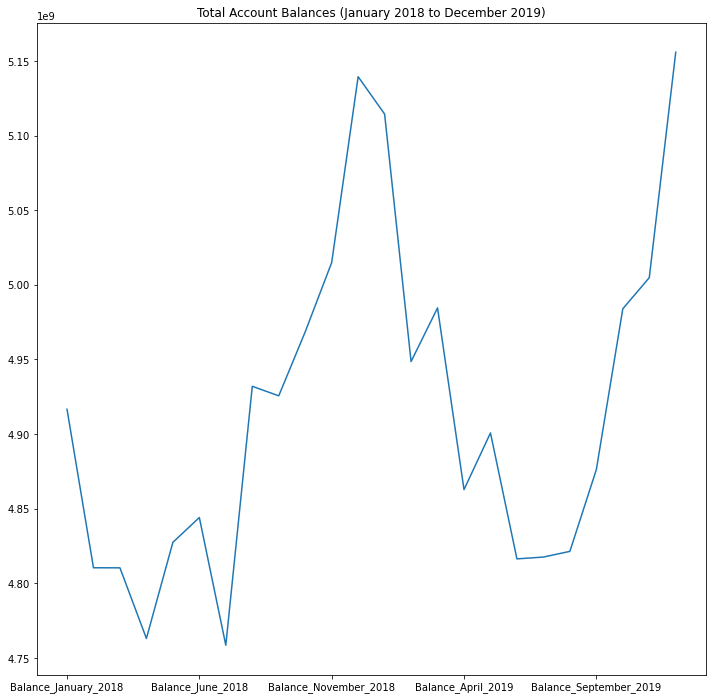

In [92]:
balances_2018_2019.plot(figsize = (12, 12))
plt.title('Total Account Balances (January 2018 to December 2019)')
plt.savefig('balances_2018_2019.png')

### Compare to Bank Negara Data

The total demand deposits every month from January 2018 to September 2020 are retrieved from Bank Negara web site at https://www.bnm.gov.my/files/publication/msb/2020/9/xls/1.24.xls

In [93]:
bnm_bals = pd.Series([
341115.1,
336065.2,
332354.4,
330216.4,
329725.1,
328801.7,
326303.1,
325980.1,
327063.9,
329227.7,
331670.4,
339880.9,
335551.6,
335942.9,
339025.7,
335578.2,
341473.1,
341703.9,
341525.1,
339600.3,
347120.8,
344918.1,
347140.3,
360385.7,
352524.3,
351612.1,
369909.6,
369822.3,
380989.1,
392343.0,
397335.4,
406291.8,
412683.1
])

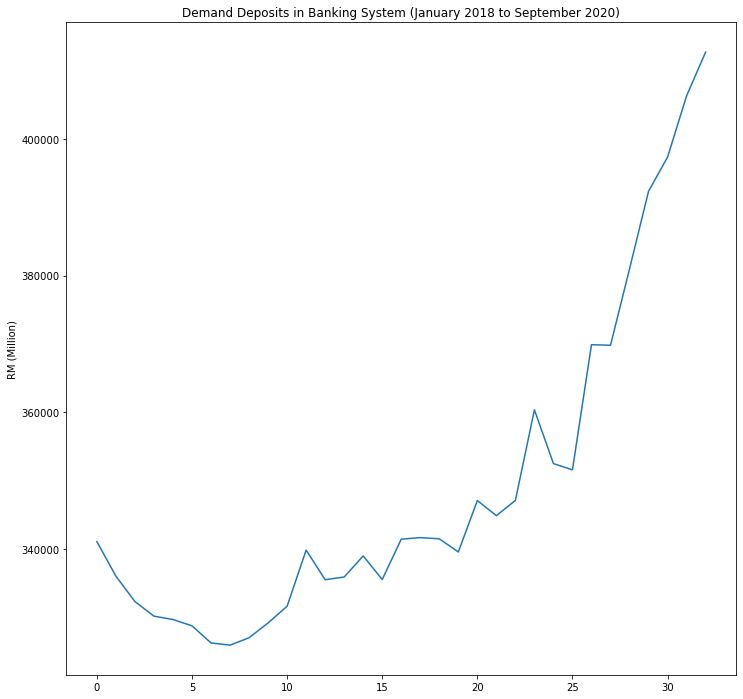

In [94]:
bnm_bals.plot(figsize = (12, 12))
plt.ylabel('RM (Million)')
plt.title('Demand Deposits in Banking System (January 2018 to September 2020)')
plt.savefig('balances_bnm.png')

The bank's total account balances over the two years look different from that of the Bank Negara for the same period. This is confirmed by positive but medium correlation calculated below.

In [95]:
correlation, p_value = stats.pearsonr(balances_2018_2019, bnm_bals[0:24])
print(correlation, p_value)

0.4375611964896059 0.03249106460312339


Pick only 4 relevant columns for model training. Save the data for future retrieval.

In [96]:
df_sme_2018_2019 = df_sme_2018_2019[['AccountID', 'BalanceMean', 'BalanceSD', 'Transactions']]

In [97]:
df_sme_2018_2019.to_csv('sme_2018_2019.csv', index = False)

## 3. Preparing Full Dataset

In this section, the 2018 and 2019 data is combined with the SME data to make the full data set.

### Joining Tables

In [98]:
df_sme_info.shape

(137159, 22)

In [99]:
df_sme_2018_2019.shape

(116607, 4)

Inner join is used to discard accounts that are missing on either table.

In [100]:
df_sme = df_sme_info.merge(df_sme_2018_2019, how = 'inner', on = 'AccountID')

### Exploring Data

In [101]:
df_sme.shape

(112618, 25)

In [102]:
df_sme.head()

,AccountID,Years,Islamic,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,Industry_Household,Industry_Logistics,Industry_Manufacturing,...,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor,ProductType_CA,ProductType_SA,BalanceMean,BalanceSD,Transactions
0,000001,19.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,27061.180000,15117.744298,44.625000
1,000002,4.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1.041667,2.074256,0.208333
2,000004,12.0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,62.964167,155.826156,3.791667
3,000005,5.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,328008.590000,111380.697708,138.750000
4,000006,15.0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,3843.160417,5122.731455,1.166667


In [103]:
df_sme.isnull().sum()

AccountID                   0
Years                       0
Islamic                     0
Industry_Agriculture        0
Industry_Construction       0
Industry_EducationHealth    0
Industry_Finance            0
Industry_Household          0
Industry_Logistics          0
Industry_Manufacturing      0
Industry_Mining             0
Industry_Others             0
Industry_RealEstate         0
Industry_Trade              0
Industry_Utilities          0
ConstType_Partnership       0
ConstType_PrivateLtd        0
ConstType_PublicLtd         0
ConstType_SchoolSociety     0
ConstType_SoleProprietor    0
ProductType_CA              0
ProductType_SA              0
BalanceMean                 0
BalanceSD                   0
Transactions                0
dtype: int64

In [104]:
df_sme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112618 entries, 0 to 112617
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountID                 112618 non-null  object 
 1   Years                     112618 non-null  float64
 2   Islamic                   112618 non-null  int64  
 3   Industry_Agriculture      112618 non-null  uint8  
 4   Industry_Construction     112618 non-null  uint8  
 5   Industry_EducationHealth  112618 non-null  uint8  
 6   Industry_Finance          112618 non-null  uint8  
 7   Industry_Household        112618 non-null  uint8  
 8   Industry_Logistics        112618 non-null  uint8  
 9   Industry_Manufacturing    112618 non-null  uint8  
 10  Industry_Mining           112618 non-null  uint8  
 11  Industry_Others           112618 non-null  uint8  
 12  Industry_RealEstate       112618 non-null  uint8  
 13  Industry_Trade            112618 non-null  u

In [105]:
df_sme.columns

Index(['AccountID', 'Years', 'Islamic', 'Industry_Agriculture',
       'Industry_Construction', 'Industry_EducationHealth', 'Industry_Finance',
       'Industry_Household', 'Industry_Logistics', 'Industry_Manufacturing',
       'Industry_Mining', 'Industry_Others', 'Industry_RealEstate',
       'Industry_Trade', 'Industry_Utilities', 'ConstType_Partnership',
       'ConstType_PrivateLtd', 'ConstType_PublicLtd',
       'ConstType_SchoolSociety', 'ConstType_SoleProprietor', 'ProductType_CA',
       'ProductType_SA', 'BalanceMean', 'BalanceSD', 'Transactions'],
      dtype='object')

In [106]:
for colname in df_sme.columns:
    print(f'Checking values for column "{colname}"')
    print(df_sme[colname].value_counts())
    print()

Checking values for column "AccountID"
066566    2
113535    2
001630    2
128261    1
018738    1
         ..
050299    1
050732    1
115120    1
137298    1
043944    1
Name: AccountID, Length: 112615, dtype: int64

Checking values for column "Years"
3.0      18008
4.0      14663
5.0      12784
2.0      12772
6.0       7093
         ...  
81.0         1
96.0         1
76.0         1
120.0        1
83.0         1
Name: Years, Length: 92, dtype: int64

Checking values for column "Islamic"
0    91040
1    21578
Name: Islamic, dtype: int64

Checking values for column "Industry_Agriculture"
0    109979
1      2639
Name: Industry_Agriculture, dtype: int64

Checking values for column "Industry_Construction"
0    97750
1    14868
Name: Industry_Construction, dtype: int64

Checking values for column "Industry_EducationHealth"
0    101792
1     10826
Name: Industry_EducationHealth, dtype: int64

Checking values for column "Industry_Finance"
0    89718
1    22900
Name: Industry_Finance, dtype: 

The product type columns are dropped as they are found to contain only one value (after previous data cleaning).

In [107]:
df_sme.drop(['ProductType_CA'], axis = 1, inplace = True)
df_sme.drop(['ProductType_SA'], axis = 1, inplace = True)

In [108]:
df_sme.head()

,AccountID,Years,Islamic,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,Industry_Household,Industry_Logistics,Industry_Manufacturing,...,Industry_Trade,Industry_Utilities,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor,BalanceMean,BalanceSD,Transactions
0,000001,19.0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,27061.180000,15117.744298,44.625000
1,000002,4.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1.041667,2.074256,0.208333
2,000004,12.0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,62.964167,155.826156,3.791667
3,000005,5.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,328008.590000,111380.697708,138.750000
4,000006,15.0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,3843.160417,5122.731455,1.166667


Save the data for future retrieval.

In [109]:
df_sme.to_csv('sme.csv', index = False)

## 4. Exploring Data

In this section, the full data set is explored using data visualization.

In [110]:
df_sme.columns

Index(['AccountID', 'Years', 'Islamic', 'Industry_Agriculture',
       'Industry_Construction', 'Industry_EducationHealth', 'Industry_Finance',
       'Industry_Household', 'Industry_Logistics', 'Industry_Manufacturing',
       'Industry_Mining', 'Industry_Others', 'Industry_RealEstate',
       'Industry_Trade', 'Industry_Utilities', 'ConstType_Partnership',
       'ConstType_PrivateLtd', 'ConstType_PublicLtd',
       'ConstType_SchoolSociety', 'ConstType_SoleProprietor', 'BalanceMean',
       'BalanceSD', 'Transactions'],
      dtype='object')

### Operating Years

Most accounts are found to have been operating for 10 years and below.

Text(0.5, 1.0, 'Operating Years')

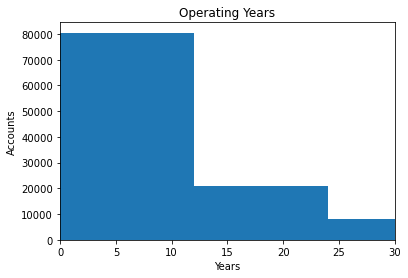

In [111]:
df_sme['Years'].plot(kind = 'hist', rot = 0)

plt.xlim(0, df_sme['Years'].quantile(0.95))
plt.xlabel("Years")
plt.ylabel("Accounts")
plt.title("Operating Years")

### Islamic Tagging

Most of the bank's customers are not found to be tagged as Islamic.

Text(0.5, 1.0, 'Islamic Tagging')

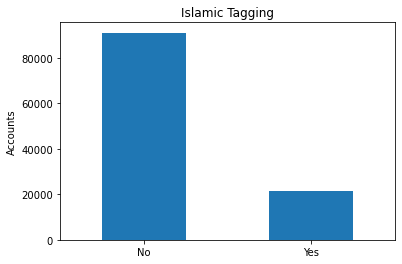

In [112]:
values = df_sme['Islamic'].value_counts()
values.plot(kind = 'bar', rot = 0)

plt.xticks(range(2), ['No', 'Yes'])
plt.ylabel("Accounts")
plt.title("Islamic Tagging")

### Industry

A majority of customers come from the trading and financial-related industries.

Text(0.5, 1.0, 'Industries')

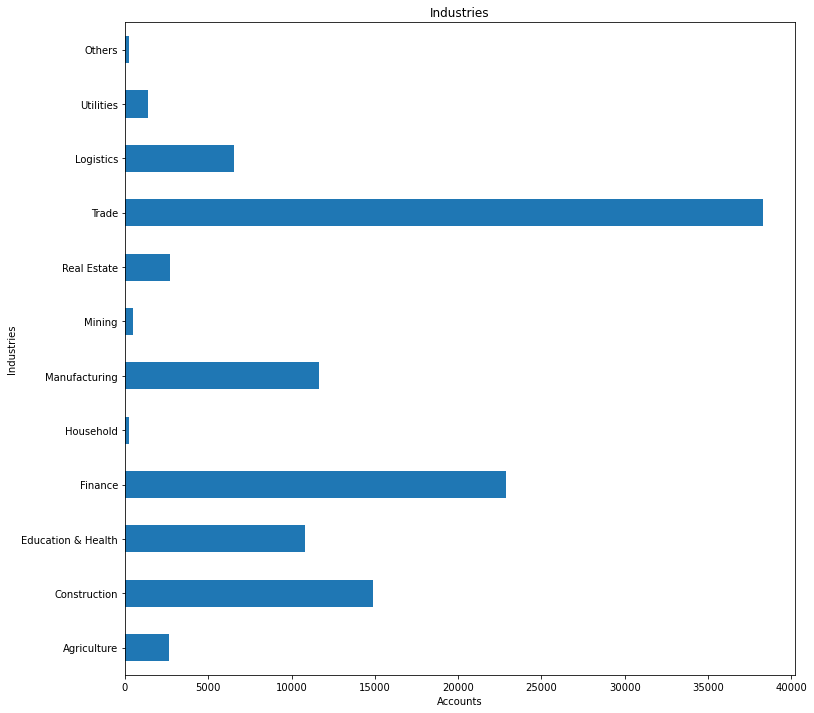

In [113]:
values = pd.DataFrame({
    'Industry': ['Agriculture', 'Construction', 'Education & Health', 'Finance', 'Household', 'Manufacturing', 'Mining', 'Real Estate', 'Trade', 'Logistics', 'Utilities', 'Others'],
    'Accounts': [df_sme['Industry_Agriculture'].sum(), df_sme['Industry_Construction'].sum(), df_sme['Industry_EducationHealth'].sum(), df_sme['Industry_Finance'].sum(), df_sme['Industry_Household'].sum(), df_sme['Industry_Manufacturing'].sum(), df_sme['Industry_Mining'].sum(), df_sme['Industry_RealEstate'].sum(), df_sme['Industry_Trade'].sum(), df_sme['Industry_Logistics'].sum(), df_sme['Industry_Utilities'].sum(), df_sme['Industry_Others'].sum()]
})
values.plot(kind = 'barh', rot = 0, figsize = (12, 12), legend = None)

plt.yticks(range(len(values)), values['Industry'])
plt.xlabel("Accounts")
plt.ylabel("Industries")
plt.title("Industries")

### Constitution Description

Most customers are found to be sole proprietors and private limited companies.

Text(0.5, 1.0, 'Constitution Description')

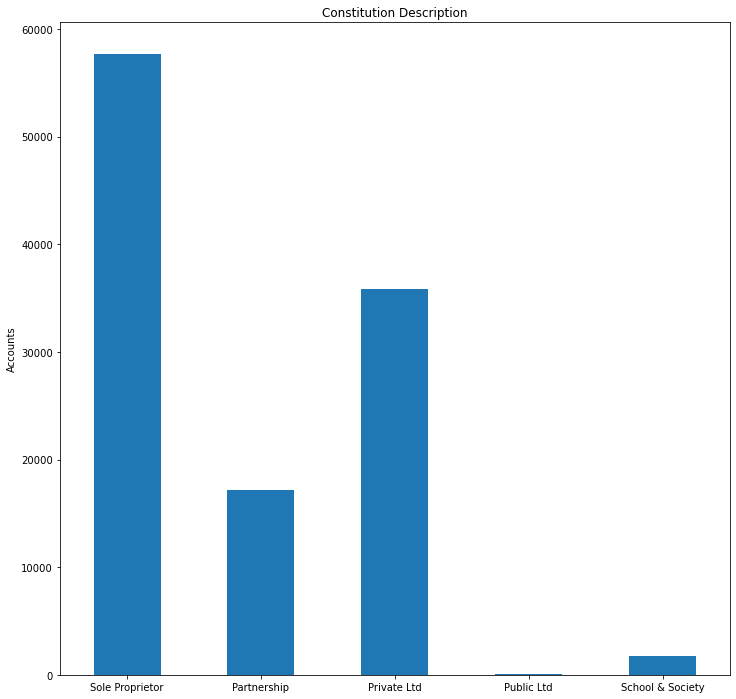

In [114]:
values = pd.DataFrame({
    'ConstType': ['Sole Proprietor', 'Partnership', 'Private Ltd', 'Public Ltd', 'School & Society'],
    'Accounts': [df_sme['ConstType_SoleProprietor'].sum(), df_sme['ConstType_Partnership'].sum(), df_sme['ConstType_PrivateLtd'].sum(), df_sme['ConstType_PublicLtd'].sum(), df_sme['ConstType_SchoolSociety'].sum()]
})
values.plot(kind = 'bar', rot = 0, figsize = (12, 12), legend = None)

plt.xticks(range(len(values)), values['ConstType'])
plt.ylabel("Accounts")
plt.title("Constitution Description")

### Average Account Balances

Most accounts are having less than RM100,000 in average account balance.

Text(0.5, 1.0, 'Account Balance - Means')

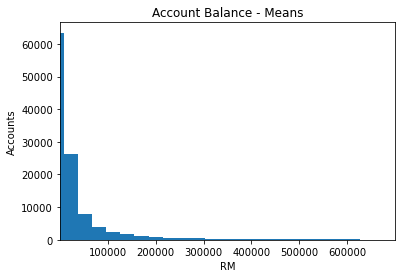

In [115]:
df_sme['BalanceMean'].plot(kind = 'hist', bins = 1000, rot = 0)

plt.xlim(df_sme['BalanceMean'].quantile(0.01), df_sme['BalanceMean'].quantile(0.99))
plt.xlabel("RM")
plt.ylabel("Accounts")
plt.title("Account Balance - Means")

### Standard Deviation of Account Balances

Most accounts are having less than RM20,000 in the standard deviation of account balances.

Text(0.5, 1.0, 'Account Balance - Standard Deviations')

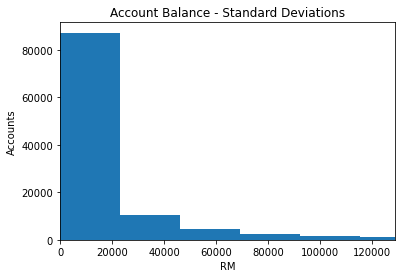

In [116]:
df_sme['BalanceSD'].plot(kind = 'hist', bins = 1000, rot = 0)

plt.xlim(0, df_sme['BalanceSD'].quantile(0.95))
plt.xlabel("RM")
plt.ylabel("Accounts")
plt.title("Account Balance - Standard Deviations")

### Transactions

Most accounts are having less than 20 average monthly number of transactions.

Text(0.5, 1.0, 'Number of Transactions')

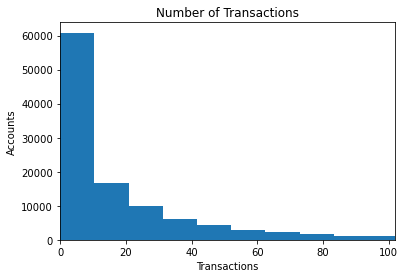

In [117]:
df_sme['Transactions'].plot(kind = 'hist', bins = 1000, rot = 0)

plt.xlim(0, df_sme['Transactions'].quantile(0.95))
plt.xlabel("Transactions")
plt.ylabel("Accounts")
plt.title("Number of Transactions")

### Check Correlations

The variables are generally not correlated to one another, except for the correlation between average account balances and standard deviation of account balances.

In [118]:
corr = df_sme.corr()
corr

,Years,Islamic,Industry_Agriculture,Industry_Construction,Industry_EducationHealth,Industry_Finance,Industry_Household,Industry_Logistics,Industry_Manufacturing,Industry_Mining,...,Industry_Trade,Industry_Utilities,ConstType_Partnership,ConstType_PrivateLtd,ConstType_PublicLtd,ConstType_SchoolSociety,ConstType_SoleProprietor,BalanceMean,BalanceSD,Transactions
Years,1.000000,-0.090794,0.012930,-0.021235,0.005572,-0.039259,0.002191,-0.020533,-0.052136,0.018268,...,0.062658,-0.020911,-0.058662,0.264384,0.015456,0.133931,-0.238332,0.096120,0.065601,-0.020798
Islamic,-0.090794,1.000000,0.014521,0.058735,-0.007754,-0.013046,-0.009352,-0.003703,0.003069,0.001396,...,-0.022179,0.003267,0.018141,-0.110298,0.003212,-0.007719,0.091492,-0.008953,-0.012896,-0.000406
Industry_Agriculture,0.012930,0.014521,1.000000,-0.060413,-0.050518,-0.078261,-0.006869,-0.038435,-0.052545,-0.010135,...,-0.111148,-0.017114,0.018525,0.028427,0.006485,-0.014986,-0.036378,0.003134,0.004962,-0.011795
Industry_Construction,-0.021235,0.058735,-0.060413,1.000000,-0.127188,-0.197036,-0.017294,-0.096767,-0.132293,-0.025516,...,-0.279837,-0.043087,-0.028492,0.023520,0.002195,-0.037592,0.007900,0.004470,0.015274,-0.034462
Industry_EducationHealth,0.005572,-0.007754,-0.050518,-0.127188,1.000000,-0.164761,-0.014461,-0.080916,-0.110623,-0.021336,...,-0.233999,-0.036029,-0.008369,-0.014079,0.011828,0.217081,-0.035708,-0.007547,-0.012043,-0.007496
Industry_Finance,-0.039259,-0.013046,-0.078261,-0.197036,-0.164761,1.000000,-0.022403,-0.125354,-0.171374,-0.033054,...,-0.362506,-0.055816,0.012338,0.003821,0.004358,0.022624,-0.018306,0.005235,0.011331,-0.006485
Industry_Household,0.002191,-0.009352,-0.006869,-0.017294,-0.014461,-0.022403,1.000000,-0.011002,-0.015041,-0.002901,...,-0.031817,-0.004899,-0.000995,-0.000129,-0.001032,-0.002424,0.001491,0.003846,0.001635,-0.001101
Industry_Logistics,-0.020533,-0.003703,-0.038435,-0.096767,-0.080916,-0.125354,-0.011002,1.000000,-0.084164,-0.016233,...,-0.178031,-0.027412,-0.012922,-0.000854,-0.002511,-0.026662,0.016885,-0.009437,-0.012704,0.013202
Industry_Manufacturing,-0.052136,0.003069,-0.052545,-0.132293,-0.110623,-0.171374,-0.015041,-0.084164,1.000000,-0.022193,...,-0.243391,-0.037476,0.023724,-0.078690,-0.006642,-0.040762,0.066746,0.014679,0.001737,0.016952
Industry_Mining,0.018268,0.001396,-0.010135,-0.025516,-0.021336,-0.033054,-0.002901,-0.016233,-0.022193,1.000000,...,-0.046944,-0.007228,-0.014915,0.060088,-0.001523,-0.008312,-0.043099,0.006942,0.010235,-0.006148


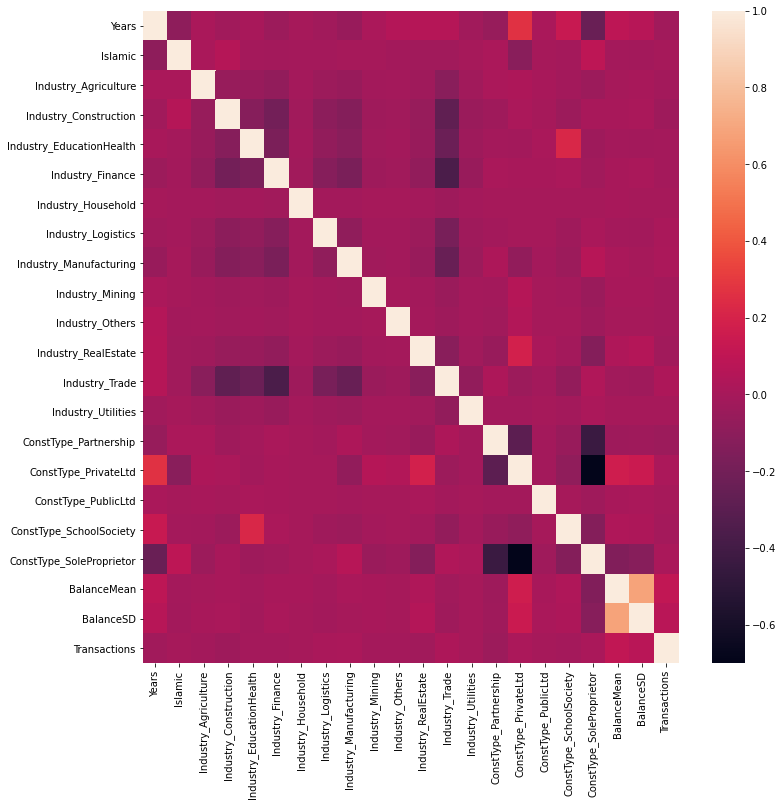

In [119]:
f, ax = plt.subplots(figsize = (12, 12))
ax = sns.heatmap(corr)

## 5. Feature Engineering

In this section, 3 feature sets are tested in model training in order to select the most suitable one. The algorithm used is k-means clustering. The sum of squares and the optimal number of clusters for each model are calculated.

### Option 1 - Full Feature Set

The full feature set includes all variables except the identifier *AccountID*.

In [120]:
FullFeatures = df_sme.drop(['AccountID'], axis = 1).columns
FullFeatures

Index(['Years', 'Islamic', 'Industry_Agriculture', 'Industry_Construction',
       'Industry_EducationHealth', 'Industry_Finance', 'Industry_Household',
       'Industry_Logistics', 'Industry_Manufacturing', 'Industry_Mining',
       'Industry_Others', 'Industry_RealEstate', 'Industry_Trade',
       'Industry_Utilities', 'ConstType_Partnership', 'ConstType_PrivateLtd',
       'ConstType_PublicLtd', 'ConstType_SchoolSociety',
       'ConstType_SoleProprietor', 'BalanceMean', 'BalanceSD', 'Transactions'],
      dtype='object')

In [121]:
scaled_features = StandardScaler().fit_transform(df_sme[FullFeatures])

In [122]:
start = 2
end = 16

sse = []

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

for k in range(start, end):
    print(f'Trying {k} clusters...')
    
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    print(f'SSE: {kmeans.inertia_}')
    
    print()

Trying 2 clusters...
SSE: 2319466.696459858

Trying 3 clusters...
SSE: 2119761.0095510995

Trying 4 clusters...
SSE: 2009942.9739554664

Trying 5 clusters...
SSE: 1908577.0152842642

Trying 6 clusters...
SSE: 1802920.4084710164

Trying 7 clusters...
SSE: 1723853.4281768263

Trying 8 clusters...
SSE: 1656353.0883730298

Trying 9 clusters...
SSE: 1551828.0486963491

Trying 10 clusters...
SSE: 1506134.3286130703

Trying 11 clusters...
SSE: 1402226.4541137686

Trying 12 clusters...
SSE: 1323822.1646250112

Trying 13 clusters...
SSE: 1287684.4499760536

Trying 14 clusters...
SSE: 1192062.64360372

Trying 15 clusters...
SSE: 1090622.8984079724



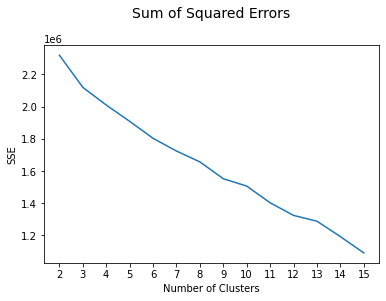

In [123]:
plt.plot(range(start, end), sse)
plt.xticks(range(start, end))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors', y = 1.1, fontsize = 14)
plt.show()

In [124]:
kl = KneeLocator(
   range(start, end), sse, curve="convex", direction="decreasing"
)

print(f'The optimal number of clusters: {kl.elbow}')
FullFeatures_clusters = kl.elbow

The optimal number of clusters: 11


### Option 2 - Reduced Feature Set

The reduced feature set does not include the industry data.

In [125]:
ReducedFeatures = ['Years', 'Islamic', 'ConstType_SoleProprietor', 'ConstType_Partnership', 'ConstType_PrivateLtd', 'BalanceMean', 'BalanceSD', 'Transactions']
ReducedFeatures

['Years',
 'Islamic',
 'ConstType_SoleProprietor',
 'ConstType_Partnership',
 'ConstType_PrivateLtd',
 'BalanceMean',
 'BalanceSD',
 'Transactions']

In [126]:
scaled_features = StandardScaler().fit_transform(df_sme[ReducedFeatures])

In [127]:
start = 2
end = 16

sse = []

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

for k in range(start, end):
    print(f'Trying {k} clusters...')
    
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    print(f'SSE: {kmeans.inertia_}')
    
    print()

Trying 2 clusters...
SSE: 706260.7599448735

Trying 3 clusters...
SSE: 552224.3394761663

Trying 4 clusters...
SSE: 471747.4508278394

Trying 5 clusters...
SSE: 404949.21155824914

Trying 6 clusters...
SSE: 351372.3279007761

Trying 7 clusters...
SSE: 315899.798478763

Trying 8 clusters...
SSE: 295240.55574222683

Trying 9 clusters...
SSE: 265115.56211014185

Trying 10 clusters...
SSE: 238124.5212034509

Trying 11 clusters...
SSE: 217473.18780357885

Trying 12 clusters...
SSE: 194882.12409160822

Trying 13 clusters...
SSE: 183407.37068514482

Trying 14 clusters...
SSE: 176427.6019858593

Trying 15 clusters...
SSE: 167830.54599255734



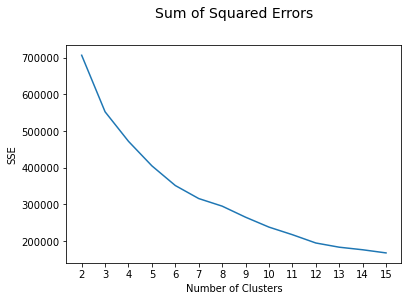

In [128]:
plt.plot(range(start, end), sse)
plt.xticks(range(start, end))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors', y = 1.1, fontsize = 14)
plt.show()

In [129]:
kl = KneeLocator(
   range(start, end), sse, curve="convex", direction="decreasing"
)

print(f'The optimal number of clusters: {kl.elbow}')
ReducedFeatures_clusters = kl.elbow

The optimal number of clusters: 6


### Option 3 - Minimum Feature Set

The minimum feature set contains only the operating years, account balances, standard deviation, and the number of transactions.

In [130]:
MinimumFeatures = ['Years', 'BalanceMean', 'BalanceSD', 'Transactions']
MinimumFeatures

['Years', 'BalanceMean', 'BalanceSD', 'Transactions']

In [131]:
scaled_features = StandardScaler().fit_transform(df_sme[MinimumFeatures])

In [132]:
start = 2
end = 16

sse = []

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

for k in range(start, end):
    print(f'Trying {k} clusters...')
    
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    print(f'SSE: {kmeans.inertia_}')
    
    print()

Trying 2 clusters...
SSE: 368465.07437714544

Trying 3 clusters...
SSE: 288347.9567039283

Trying 4 clusters...
SSE: 234350.7567271866

Trying 5 clusters...
SSE: 216638.37444703866

Trying 6 clusters...
SSE: 169521.6911915696

Trying 7 clusters...
SSE: 146759.8687993306

Trying 8 clusters...
SSE: 125516.60982447067

Trying 9 clusters...
SSE: 119265.11303884845

Trying 10 clusters...
SSE: 108794.81688072217

Trying 11 clusters...
SSE: 99687.48471695246

Trying 12 clusters...
SSE: 91480.58008124503

Trying 13 clusters...
SSE: 87932.92739542064

Trying 14 clusters...
SSE: 83454.24250713881

Trying 15 clusters...
SSE: 78280.35605678626



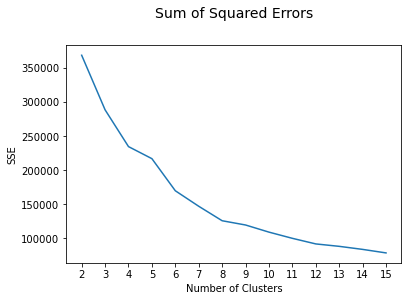

In [133]:
plt.plot(range(start, end), sse)
plt.xticks(range(start, end))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Sum of Squared Errors', y = 1.1, fontsize = 14)
plt.show()

In [134]:
kl = KneeLocator(
   range(start, end), sse, curve="convex", direction="decreasing"
)

print(f'The optimal number of clusters: {kl.elbow}')
MinimumFeatures_clusters = kl.elbow

The optimal number of clusters: 7


### Final Feature Set

The reduced feature set produces the minimum number of clusters, that is, 6 clusters. It is chosen to ease analysis later, where we will include non-customer segments in the market as well. Moreover, it results in clusters that are more balanced in numbers, as will be shown below.

In contrast, the minimum feature set produces 7 clusters, just one more cluster than the reduced feature set. But the clusters are not balanced in numbers.

In [135]:
FinalFeatures = ReducedFeatures
FinalClusters = ReducedFeatures_clusters

print(FinalFeatures)
print(FinalClusters)

['Years', 'Islamic', 'ConstType_SoleProprietor', 'ConstType_Partnership', 'ConstType_PrivateLtd', 'BalanceMean', 'BalanceSD', 'Transactions']
6


## 6. Model Training

In this section, the model is trained based on the chosen feature set. The resulting clusters are explored using data visualization.

In [136]:
scaled_features = StandardScaler().fit_transform(df_sme[FinalFeatures])

In [137]:
# set number of clusters
kclusters = FinalClusters

kmeans = KMeans(n_clusters = kclusters, **kmeans_kwargs)
kmeans.fit(scaled_features)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_ + 1
labels

array([1, 5, 5, ..., 4, 4, 1])

Each account in data set is labeled with the cluster number it belongs to.

In [138]:
df_model = df_sme[FinalFeatures]
df_model.insert(0, 'AccountID', df_sme['AccountID'])
df_model = df_model.assign(Cluster = labels)
df_model.head()

,AccountID,Years,Islamic,ConstType_SoleProprietor,ConstType_Partnership,ConstType_PrivateLtd,BalanceMean,BalanceSD,Transactions,Cluster
0,000001,19.0,0,0,1,0,27061.180000,15117.744298,44.625000,1
1,000002,4.0,1,1,0,0,1.041667,2.074256,0.208333,5
2,000004,12.0,1,1,0,0,62.964167,155.826156,3.791667,5
3,000005,5.0,0,0,0,1,328008.590000,111380.697708,138.750000,4
4,000006,15.0,1,0,0,1,3843.160417,5122.731455,1.166667,4


Save the model and data for future retrieval.

In [139]:
joblib.dump(kmeans, 'model.pkl')

['model.pkl']

In [140]:
df_model.to_csv('model.csv', index = False)

### Exploring Clusters

It is found that cluster 2 and 4 are the largest clusters. Clusters 1 and 5 are medium in size. Clusters 3 and 6 are small but not insignificant.

In [141]:
df_plot = pd.DataFrame(df_model['Cluster'].value_counts(sort = False))
df_plot.index.name = 'Cluster'
df_plot.columns = ['Count']
df_plot

,Count
Cluster,
1,17180
2,45145
3,531
4,36146
5,13321
6,295


In [142]:
total = df_plot['Count'].sum()
total

112618

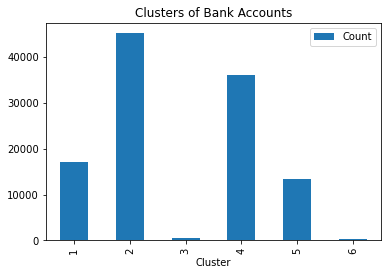

In [143]:
df_plot.plot.bar(title = 'Clusters of Bank Accounts')

Data is grouped by cluster for further analysis.

In [144]:
df_clusters = df_model.groupby('Cluster')
df_clusters

Clusters 3 and 4 are longer in the number of operating years. Cluster 6 is the youngest one.

In [145]:
df_clusters['Years'].mean()

Cluster
1     8.351630
2     7.834002
3    17.386064
4    14.023682
5     6.405750
6     3.701695
Name: Years, dtype: float64

The whole of cluster 5 is found to be tagged as Islamic.

In [146]:
df_clusters['Islamic'].mean()

Cluster
1    0.208265
2    0.000000
3    0.177024
4    0.125353
5    1.000000
6    0.183051
Name: Islamic, dtype: float64

Clusters 2, 5 and 6 consist of mostly sole proprietors.

In [147]:
df_clusters['ConstType_SoleProprietor'].mean()

Cluster
1    0.000000
2    0.983320
3    0.048964
4    0.000221
5    0.978755
6    0.898305
Name: ConstType_SoleProprietor, dtype: float64

All accounts in cluster 1 are partnerships.

In [148]:
df_clusters['ConstType_Partnership'].mean()

Cluster
1    1.000000
2    0.000000
3    0.056497
4    0.000111
5    0.000000
6    0.006780
Name: ConstType_Partnership, dtype: float64

Clusters 3 and 4 are mostly private limited companies.

In [149]:
df_clusters['ConstType_PrivateLtd'].mean()

Cluster
1    0.000000
2    0.000000
3    0.843691
4    0.977923
5    0.000000
6    0.091525
Name: ConstType_PrivateLtd, dtype: float64

Cluster 3 consists of account whose balances are in the millions. The other clusters are in tens of thousands, with clusters 4 and 6 having more.

In [150]:
df_clusters['BalanceMean'].mean()

Cluster
1    2.772243e+04
2    1.639355e+04
3    2.001850e+06
4    7.449774e+04
5    1.592744e+04
6    6.586753e+04
Name: BalanceMean, dtype: float64

Cluster 3 is having movements in account balances in the millions. The rest are in the tens of thousands, with clusters 4 and 6 having more.

In [151]:
df_clusters['BalanceSD'].mean()

Cluster
1    1.816900e+04
2    1.180844e+04
3    1.448300e+06
4    5.167556e+04
5    1.160349e+04
6    4.145095e+04
Name: BalanceSD, dtype: float64

Cluster 6 is having the highest monthly number of transactions, followed by cluster 3.

In [152]:
df_clusters['Transactions'].mean()

Cluster
1      17.844521
2      24.054532
3     114.100910
4      29.471344
5      23.568448
6    1556.166949
Name: Transactions, dtype: float64

### Visualizing Clusters

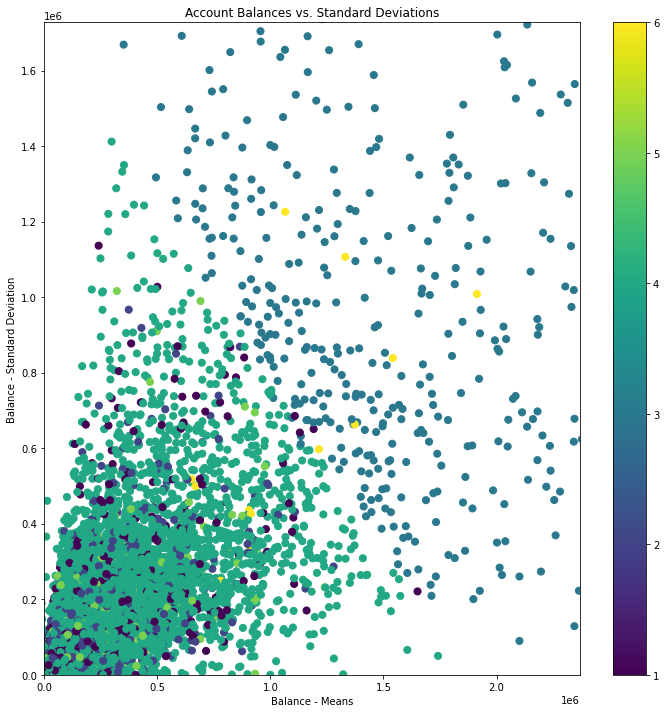

In [153]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)

scatter = ax.scatter(df_model['BalanceMean'], df_model['BalanceSD'], c = df_model['Cluster'], s = 50)

ax.set_title('Account Balances vs. Standard Deviations')
ax.set_xlabel('Balance - Means')
ax.set_ylabel('Balance - Standard Deviation')
ax.set_xlim(0, df_model['BalanceMean'].quantile(0.999))
ax.set_ylim(0, df_model['BalanceSD'].quantile(0.999))

plt.colorbar(scatter)

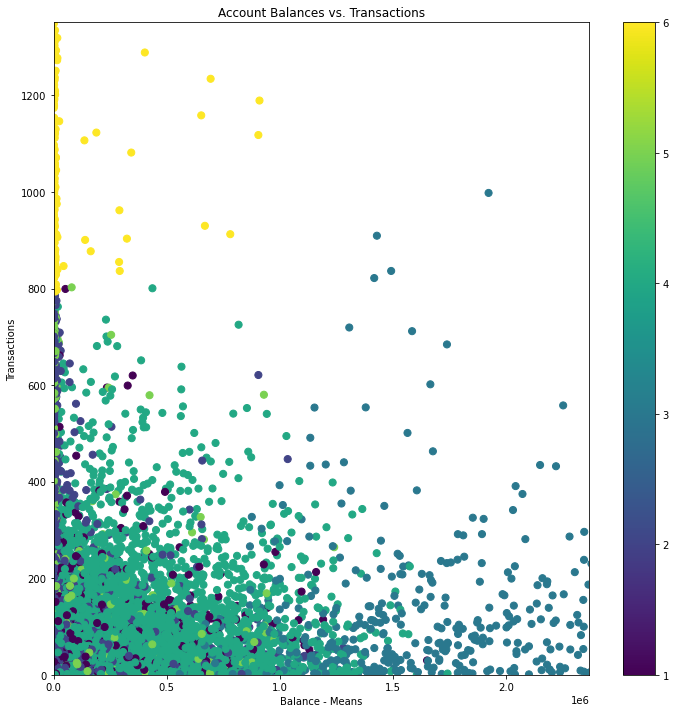

In [154]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)

scatter = ax.scatter(df_model['BalanceMean'], df_model['Transactions'], c = df_model['Cluster'], s = 50)

ax.set_title('Account Balances vs. Transactions')
ax.set_xlabel('Balance - Means')
ax.set_ylabel('Transactions')
ax.set_xlim(0, df_model['BalanceMean'].quantile(0.999))
ax.set_ylim(0, df_model['Transactions'].quantile(0.999))

plt.colorbar(scatter)

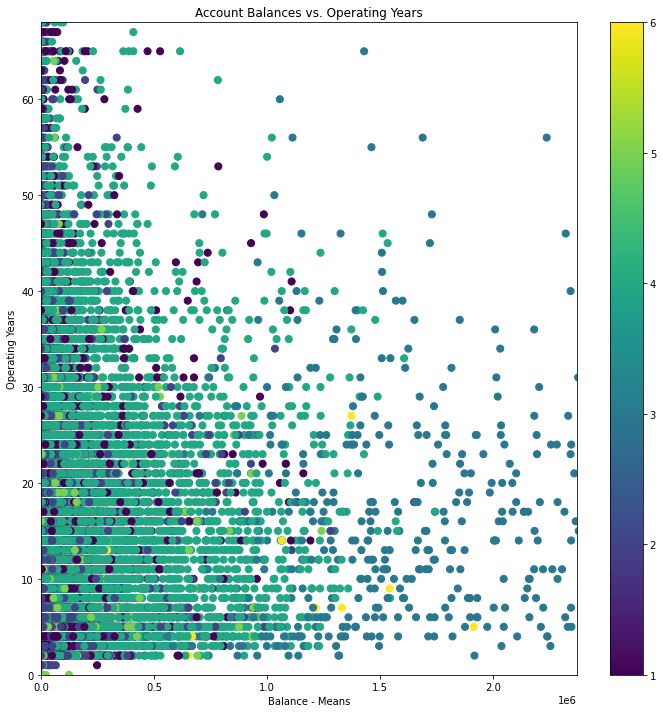

In [155]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111)

scatter = ax.scatter(df_model['BalanceMean'], df_model['Years'], c = df_model['Cluster'], s = 50)

ax.set_title('Account Balances vs. Operating Years')
ax.set_xlabel('Balance - Means')
ax.set_ylabel('Operating Years')
ax.set_xlim(0, df_model['BalanceMean'].quantile(0.999))
ax.set_ylim(0, df_model['Years'].quantile(0.999))

plt.colorbar(scatter)

## 7. Discussion

### Interpreting Clusters

| **Cluster** | **Accounts** | **Years** | **Type** | **Balances** | **Movements** | **Transactions** |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 1 | 17,180 | 8.4 | Partnership | 28K | 18K | 18 |
| 2 | 45,145 | 7.8 | Sole Proprietor | 16K | 12K | 24 |
| 3 | 531 | 17.4 | Private Ltd | 2M | 1.4M | 114 |
| 4 | 36,146 | 14.0 | Private Ltd | 74K | 52K | 29 |
| 5 | 13,321 | 6.4 | Sole Proprietor + Islamic | 16K | 12K | 24 |
| 6 | 295 | 3.7 | Sole Proprietor | 66K | 41K | 1556 |

**Cluster 1** - Partnerships.

**Cluster 2** - Sole proprietors. Low in account balances.

**Cluster 3** - Private limited companies. Long in operating years. High in account balances. Active in business transactions.

**Cluster 4** - Private limited companies. Long in operating years. 

**Cluster 5** - Islamic sole proprietors. Low in account balances.

**Cluster 6** - Sole proprietors. Very active in business transactions.